In [27]:
import argparse
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL.Image as Image

from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
from skimage.measure import label
from skimage.measure import regionprops


def adjustment(ImageName, Alpha=1.7, Beta=0):
        # Alphafactor for contrast control
        # Beta for brightness control

    img = cv2.imread(ImageName, 0)
    img = np.array(img, dtype=np.uint8)
    img2 = cv2.convertScaleAbs(img, alpha=Alpha, beta=Beta)
    kernel = np.ones((5, 5), np.uint8)
    opening2 = cv2.morphologyEx(img2, cv2.MORPH_OPEN, kernel)
    canny2 = cv2.Canny(opening2, 100, 150, 3, L2gradient=True)
    return canny2, img2


def compare(major_axis, minor_axis):
    """ This function gives the plot of major axis vs minor axis of the ellipse
    and compares it with the circle.
    Arguments:
    major_axis = It is the long axis of the ellipse
    minor_axis = It is the short axis of the ellipse"""
    plt.clf()
    p = np.array(range(100))
    q = np.array(range(100))
    plt.scatter(major_axis, minor_axis)
    plt.plot(p, q)
    plt.xlim(0, 80)
    plt.ylim(0, 80)
    plt.xlabel("Maximum")
    plt.ylabel("Minimum")
    plt.title("Plot of Minimum vs Maximum")
    plt.legend(["Theoretical circle", "Predicted Circle"])
    return


def get_circles(img, dp=3, minDist=20, para1=150, para2=50, minradius=0, maxradius=30):
    """ The following functions takes in the gray scale image and returns the radius of the circle and the image.
    Arguments:
    image: Gray scale image input
    dp: Inverse ratio of the accumulator resolution to the image resolution.
    minDist: Minimum distance between the centers of the detected circles.
    para1 : It is the higher threshold of the two passed to the Canny edge
    para2 : It is the accumulator threshold for the circle centers at the detection stage.
    minRadius : Minimum circle radius.
    maxRadius : Maximum circle radius. """
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp, minDist,
                               param1=para1, param2=para2, minRadius=minradius, maxRadius=maxradius)
    circles = np.uint16(np.around(circles))
    circle_radii = circles[0][:, 2]
    for i in circles[0, :]:
        # draw the outer circle
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # draw the center of the circle
        cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)
    return (circle_radii, img)


def getConv(name, mag=0):
    mag = getMag(name, mag)
    
    conv = pd.DataFrame([[0, 0, 0, 0],[35000, 157, 2000, 12.7388535], [25000, 111, 2000, 18.01801802], [15000, 167, 5000, 29.94011976], [
                        12000, 133, 5000, 37.59398496], [10000, 111, 5000, 45.04504505], [6500, 15, 10000, 68.96551724]])
    conv.columns = ['Mag', 'Pixels', 'Length [nm]', 'Conversion']
    
    # Finds row that matches the magnification value
    row = conv.loc[conv['Mag'] == mag]
    convFactor = row.iloc[0]['Conversion']  # Gets conversion factor from row

    print("Magnification Level: " + str(mag) + "x")
    print("Conversion Factor [nm/pixel]: " + str(convFactor))
    print("-----------------------------------------------------")

    return convFactor


def get_ellipse(canny_image, mean_contour_Area):
    """This function returns the major and the minor axis of the ellipse.
    Arguments:
    canny_image : The image whose edges are delected
    mean_countour_Area : The mean area of the contours found using the image segmentation   """
    th, threshed = cv2.threshold(canny_image, 120, 255, cv2.THRESH_BINARY)
    threshed = cv2.dilate(threshed, None)
    threshed = cv2.erode(threshed, None)
    # Finding the countours of the image
    cnts = cv2.findContours(threshed, cv2.RETR_CCOMP,
                            cv2.CHAIN_APPROX_SIMPLE)[-2]
    # Draws the Contours
    cv2.drawContours(canny_image, cnts, -1, (157, 0, 78), 1, cv2.LINE_AA)
    # Calculating the range of the area
    Mean_Area = mean_contour_Area
    Lower_Area = Mean_Area - 0.1 * Mean_Area
    Higher_Area = Mean_Area + 0.1 * Mean_Area
    elps = []
    for cnt in cnts:
        if cnt.size in range(100, 200) or Lower_Area <= (cv2.contourArea(cnt)) <= Higher_Area:
            # Fitting the ellipse
            Ellipse = cv2.fitEllipse(cnt)
            # Adding rllipse to the list
            elps.append(Ellipse)
            cv2.ellipse(canny_image, Ellipse, (255, 0, 0), 2, cv2.LINE_AA)
        # Getting the major and minor axis of the Ellipse
        axes = [x[1] for x in elps]
        major_axis = [y[1] for y in axes]
        minor_axis = [z[0] for z in axes]
    return(major_axis, minor_axis)


def getMag(name, mag=0):
    img = cv2.imread(name)  # Image to be analyzed

    while True:
        try:
            import pytesseract
            pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'
            # Crops image to magn. details, increases reliability of OCR
            magCrop = img[443:465, 168:240]
            # Inverts colors, easier for OCR software to read
            magCropInv = cv2.bitwise_not(magCrop)
            mag = int(pytesseract.image_to_string(Image.fromarray(magCropInv))[
                      :-1])  # Image to text, removes 'x', makes integer
            print("Using tesseract OCR...")
            break
        except:
            try:
                # Splits file name by underscores, stores in list
                spl1 = name.split('_')
                # Selects the last list entry (number.TIF) and splits by
                # period, stores in list
                spl2 = spl1[-1].split('.')
                # Selects the first list entry (number) and converts to integer
                mag = int(spl2[0])
                print("Using file name...")
                break
            except:
                #**********USER INPUT**********
                print("Using user input...")
                print(
                    "If you did not manually enter this magnification level, results will likely be wrong!")
                mag = mag
                break
    return mag


def imageseg(Cont_Image):
    """imageseg('Image Name')
        
    This program takes an image that has been pre-proccessed by an edge finding script as its sole input, segments it, and spits out a segmented image file and a pandas dataframe of individual particle positions.
    
    This function works by creating a binary of an image that has been run through edge detection software, then finding the center of those particles through an Euclidean Distance function.  This was chosen over the typical watershed iterative erosion method because of its increased control in finding the center of particles, allowing for greater detection of overlapped and small particles.
    
    Methodology ideas pulled from the SciKit Image example pages (https://scikit-image.org) as well as the Open CV example pages (https://opencv.org) and Adrian Rosebrock's blog (https://www.pyimagesearch.com/2015/09/14/ball-tracking-with-opencv/)."""

    proccessedImage = np.array(Cont_Image, dtype=np.uint8)
    
    kernel = np.ones((5,6), np.uint8)
    opening = cv2.morphologyEx(Cont_Image, cv2.MORPH_OPEN, kernel)
    canny = cv2.Canny(opening,100,150,3,L2gradient=True)
    
    ret, binary = cv2.threshold(Cont_Image,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    distTransform = ndimage.distance_transform_bf(binary)
    localMax = peak_local_max(distTransform, indices=False, min_distance=20,labels=binary)
    label = ndimage.label(localMax)[0]
    segments = watershed(-distTransform, label, mask=binary)

    segment_locations = segmentparser(segments, binary)

    return segments, segment_locations, opening, canny


def predict_shape(major_axis, minor_axis):
    """ This function predicts whether the object detected is circle or ellispeIt is the short axis of the ellipse
    It returns number of circles or the ellipse in the image
    Arguments:
    major_axis = It is the long axis of the ellipse
    minor_axis = It is the short axis of the ellipse    """
    circular_particle = 0
    ellipsoidal_particle = 0
    for i in range(len(major_axis)):
        x = 0.1 * major_axis[i] + major_axis[i]
        y = major_axis[i] - 0.1 * major_axis[i]
        if minor_axis[i] <= x and minor_axis[i] >= y:
            circular_particle += 1
        else:
            ellipsoidal_particle += 1
    return(circular_particle, ellipsoidal_particle)


def segmentparser(segmented_image, binary):
    """Takes an edge detected image and an image binary and returns a Pandas dataframe of the x-y coordinates and area of the image segments.  Both the edge detected image and the binary of the image should be 1D image files of the same size.
        
        Code courtesy Chad Curtis, pulled from L9 Image Proccessing Lecture.
        
        Parameters:
        -----------
        Edge Detected Image: 2D array
        Output of an edge detection program/canny edge detection algorithm.
        Image Binary: 2D array
        Bitmap/binary image (should only contain 1's and 0's.
        segment_properties: Pandas dataframe, four columns
        Example:
        X               Y               Area
        0       436.629412      436.629412      170.0
        1       55.029162       55.029162       4835.0
        2       662.983593      662.983593      1219.0
        ...     ...             ...             ...
    
    Code courtesy Chad Curtis, pulled from L9 Image Proccessing Lecture"""
    
    props = regionprops(segmented_image, intensity_image=binary)
    x = y = area = perimeter = intensity = np.zeros(len(props))

    index_i = 0

    for index_j in props:
        x[index_i] = index_j.centroid[0]
        y[index_i] = index_j.centroid[1]
        area[index_i] = index_j.area
        
        index_i = index_i + 1
    
    segment_properties = pd.DataFrame({'X': x, 'Y': y, 'Area': area})

    return segment_properties


def output(name, mag=0, Alpha=1.7, Beta=0, dp=3, minDist=20, para1=150, para2=50, minradius=0, maxradius=30, mean_contour_Area=1200):
    
    imageInput = cv2.imread(name, 0)
    convFactor = getConv(name, mag)
    
    canny2, img2 = adjustment(name, Alpha, Beta)
    
    circle_radii, circ_img = get_circles(imageInput, dp, minDist, para1, para2, minradius, maxradius)
    major_axis, minor_axis = get_ellipse(canny2, mean_contour_Area)
    segments, segment_locations, opening, canny = imageseg(canny2)
    
    circular_particle, ellipsoidal_particle = predict_shape(major_axis, minor_axis)
    
    meanRadius = round(np.mean(circle_radii)*convFactor)
    stdRadius = round(np.std(circle_radii)*convFactor)
    maxRadius = round(np.max(circle_radii)*convFactor)
    minRadius = round(np.min(circle_radii)*convFactor)
    circleCount = np.size(circle_radii)
    ellipseCount = np.size(major_axis)
    
    data = [['Mean', meanRadius], ['Standard Deviation', stdRadius], ['Maximum', maxRadius], ['Minimum', minRadius], ['Circle Count', circleCount], ['Ellipse Count', ellipseCount]]
    outputDF = pd.DataFrame(data, columns = ['Statistic', 'Value'])
    display(outputDF)

    fig, ax = plt.subplots(4, 2, figsize=(50,50))
    ax[0,0].imshow(imageInput) # Image input
    ax[0,1].imshow # Contrast adjusted image
    ax[1,0].imshow # Segmentation type 1
    ax[1,1].imshow(segments) # Segmentation type 2
    ax[2,0].imshow(circ_img) # Circle Fit image
    ax[2,1].imshow # Ellipse Fit image
    ax[3,0].imshow #Major vs Minor axis plot
    ax[3,1].imshow # Data table
    
    return

In [28]:
# Edit this cell!
name = 'Opal_Tecopa_near_gem.jpg'

# Defaults to zero. Input the magnification factor of the image.
mag = 10000

Using user input...
If you did not manually enter this magnification level, results will likely be wrong!
Magnification Level: 10000x
Conversion Factor [nm/pixel]: 45.04504505
-----------------------------------------------------


,Statistic,Value
0,Mean,802.0
1,Standard Deviation,308.0
2,Maximum,1261.0
3,Minimum,360.0
4,Circle Count,82.0
5,Ellipse Count,15.0


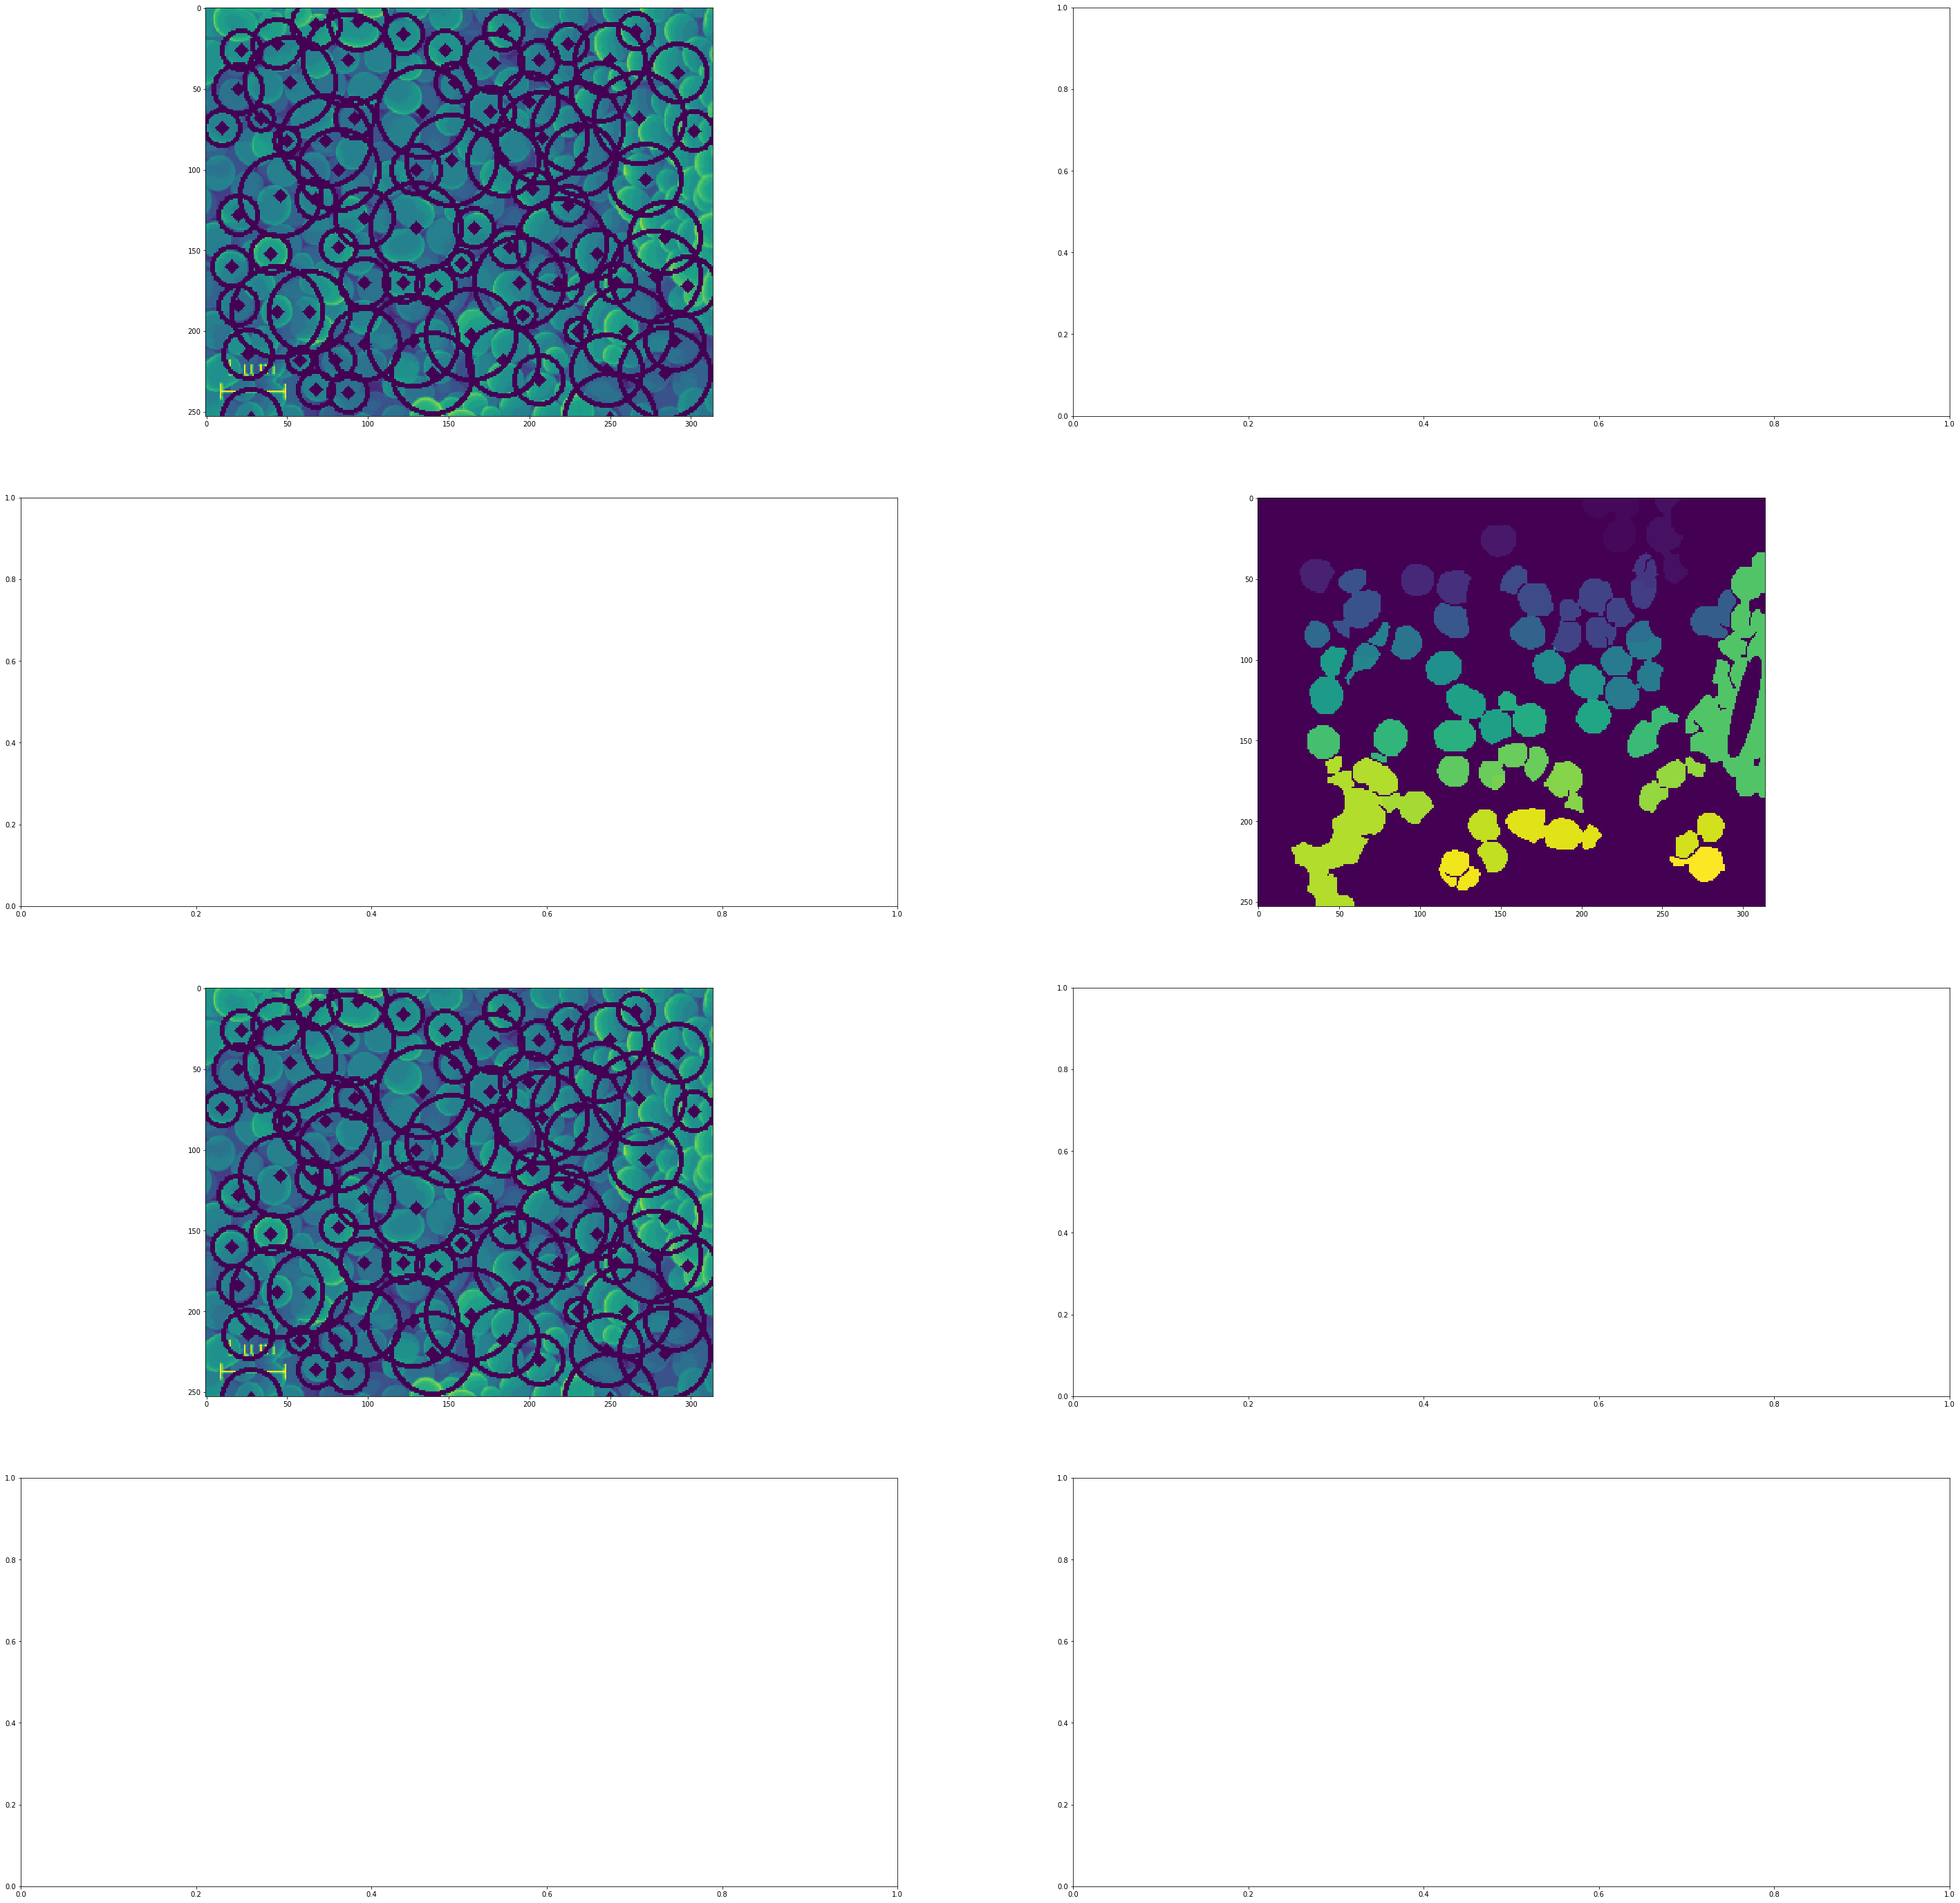

In [29]:
output(name, mag)